## Keras CapsNet MNIST

Examples of image recognition on the MNIST dataset using Keras using CapsNet.

Caps note code is adapted from: https://github.com/XifengGuo/CapsNet-Keras

In [29]:
import os
import numpy as np
import pandas as pd
from time import time
#from scipy.misc import imread
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras
import keras.backend as K

from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras import layers, models, optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt

Some shared functions

In [11]:
def score_model(model, X_test, y_test):
    """ 
    Evaluate and show a models scores 
    
    Args: 
        model: The model to score 
        X_test: test set
        y_test: labels for the test set
        
    Returns: 
    
    """
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    print("Baseline Error: %.2f%%" % (100-score[1]*100))

def plot_model_accuracy_loss(history):
    """ 
    Show plots of train v's test accuracy and loss. 
    
    Args: 
        history: history returned from fitting a model 
        
    Returns: 
    
    """
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history.history['acc'])  
    plt.plot(history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
   
    # summarize history for loss     
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    
    plt.tight_layout()
    
def plot_sample_predictions(model, X_test, X_test_reshaped, y_test):
    """ 
    Show plots of sample predictions 
    
    Args: 
        model: The model to evaluate 
        X_test: test set
        X_test_reshaped: test set reshaped if needed for the model
        y_test: labels for the test set
        
    Returns: 
    
    """
    # The predict_classes function outputs the highest probability class# The pr 
    # according to the trained classifier for each input example.
    predicted_classes = model.predict_classes(X_test_reshaped)
    
    # Show some items we got right
    fig=plt.figure(figsize=(8, 8))
    plt.suptitle('Samples of Correct Predictions', fontsize="x-large")
    correct_indices = np.nonzero(predicted_classes == y_test)[0]
    for i, correct in enumerate(correct_indices[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    # shift subplots down:
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Show some items we got wrong
    fig=plt.figure(figsize=(8, 8))
    plt.suptitle('Samples of Incorrect Predictions', fontsize="x-large")
    incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
    for i, incorrect in enumerate(incorrect_indices[:9]):
        plt.subplot(3,3,i+1)
        plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    # shift subplots down:
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


Load the mnist data and show a few samples

In [12]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [18]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


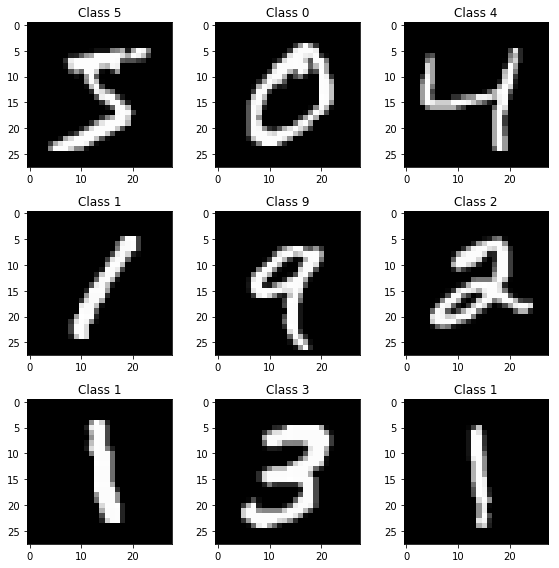

In [19]:
fig=plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.title("Class {}".format(y_train[i]))
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
plt.tight_layout()

The pixel values are gray scale between 0 and 255. It is almost always a good idea to perform some scaling of input values when using neural network models. Because the scale is well known and well behaved, we can very quickly normalize the pixel values to the range 0 and 1 by dividing each value by the maximum of 255.

In [20]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

Finally, the output variable is an integer from 0 to 9. As this is a multi-class classification problem we need to one hot encoding of the class values, transforming the vector of class integers into a binary matrix.

We can easily do this using the built-in np_utils.to_categorical() helper function in Keras.

In [21]:
# one hot encode outputs and save original classes
print(y_train.shape)
print(y_test.shape)
print(y_train[:10])
y_train_classes = y_train.copy()
y_test_classes = y_test.copy()
y_train = np_utils.to_categorical(y_train_classes)
y_test = np_utils.to_categorical(y_test_classes)
num_classes = y_test.shape[1]
print(y_train.shape)
print(y_test.shape)
print(y_train[:3])

(60000,)
(10000,)
[5 0 4 1 9 2 1 3 1 4]
(60000, 10)
(10000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Model

The training dataset is structured as a 3-dimensional array of (instance, image width and image height). Our neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector.

We can do this transform easily using the reshape() function on the NumPy array. We can also reduce our memory requirements by forcing the precision of the pixel values to be 32 bit, the default precision used by Keras anyway.

In [23]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


We use a CapsNet - code from https://github.com/XifengGuo/CapsNet-Keras

In [24]:
def CapsNet(input_shape, n_class, routings):
   """
   A Capsule Network on MNIST.
   :param input_shape: data shape, 3d, [width, height, channels]
   :param n_class: number of classes
   :param routings: number of routing iterations
   :return: Two Keras Models, the first one used for training, and the second one for evaluation.
   `eval_model` can also be used for training.
   """
   x = layers.Input(shape=input_shape)

   # Layer 1: Just a conventional Conv2D layer
   conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

   # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
   primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

   # Layer 3: Capsule layer. Routing algorithm works here.
   digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
   name='digitcaps')(primarycaps)

   # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
   # If using tensorflow, this will not be necessary. :)
   out_caps = Length(name='capsnet')(digitcaps)

   # Decoder network.
   y = layers.Input(shape=(n_class,))
   masked_by_y = Mask()([digitcaps, y]) # The true label is used to mask the output of capsule layer. For training
   masked = Mask()(digitcaps) # Mask using the capsule with maximal length. For prediction

   # Shared Decoder model in training and prediction
   decoder = models.Sequential(name='decoder')
   decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
   decoder.add(layers.Dense(1024, activation='relu'))
   decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
   decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

   # Models for training and evaluation (prediction)
   train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
   eval_model = models.Model(x, [out_caps, decoder(masked)])

   # manipulate model
   noise = layers.Input(shape=(n_class, 16))
   noised_digitcaps = layers.Add()([digitcaps, noise])
   masked_noised_y = Mask()([noised_digitcaps, y])
   manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
   return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):
   """
   Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
   :param y_true: [None, n_classes]
   :param y_pred: [None, num_capsule]
   :return: a scalar loss value.
   """
   L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
   0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

   return K.mean(K.sum(L, 1))

In [25]:
model, eval_model, manipulate_model = CapsNet(input_shape=X_train.shape[1:],
 n_class=len(np.unique(np.argmax(y_train, 1))),
 routings=3)

# compile the model
model.compile(optimizer=optimizers.Adam(lr=0.001),
 loss=[margin_loss, 'mse'],
 loss_weights=[1., 0.392],
 metrics={'capsnet': 'accuracy' : 'out_caps'})

model.summary()

Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
______________________________________________

Setup callback for tensor board logging, saving weights and early stopping. To start tensorboard, change to the folder containing the logs directory and run:

tensorboard --logdir=logs/

In [30]:
tf_callback= TensorBoard(log_dir="logs/keras_capsnet/{}".format(time()), 
                                            histogram_freq=1, write_graph=True, write_images=True)
checkpointer = ModelCheckpoint(filepath='Keras CapsNet.Model.Best.hdf5', 
                               verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')

Instructions for updating:
Use the retry module or similar alternatives.


Fit the model

In [32]:
def train_generator(x, y, batch_size, shift_fraction=0.1):
    train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
    height_shift_range=shift_fraction) # shift up to 2 pixel for MNIST
    generator = train_datagen.flow(x, y, batch_size=batch_size)
    while 1:
        x_batch, y_batch = generator.next()
        yield ([x_batch, y_batch], [y_batch, x_batch])

# Training with data augmentation. If shift_fraction=0., also no augmentation.
history = model.fit_generator(generator=train_generator(X_train, y_train, 1000, 0.1),
                              steps_per_epoch=int(y_train.shape[0] / 1000), epochs=5,
                              validation_data=[[X_test, y_test], [y_test, X_test]],
                              verbose=2, callbacks=[tf_callback, checkpointer, earlystopping])

Epoch 1/5


KeyboardInterrupt: 

Load back in the best weights

In [ ]:
model.load_weights('Keras CapsNet.Model.Best.hdf5')

Final evaluation of the model

In [ ]:
score_model(model, X_test, y_test)

Plot accuracy and loss for train / test sets to see if more epochs would have helped and to ensure that we don't start overfitting.

Here we should probably have stopped after 4 epochs!

In [ ]:
plot_model_accuracy_loss(history)

### Inspect the output
Manually inspect the output to check everything looks as expected

In [ ]:
plot_sample_predictions(model, X_test, X_test, y_test_classes)